# Metric Learning with Large Margin Nearest Neighbors

In [14]:
# ignore warnings due to deprecation 
import warnings
warnings.filterwarnings("ignore")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng
import numpy.linalg as alg

import copy
import metric_learn

from scipy.ndimage import imread, affine_transform
from scipy.spatial.distance import cdist, pdist
from skimage.measure import block_reduce
from skimage.transform import rescale, resize, downscale_local_mean
from functools import reduce
from PIL import Image

import os


#### All of the images were dumped into one folder in order to pull images for visualization/training:


In [17]:
allFiles = ' '
rootDir ="./DumpPNG/"
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        allFiles = allFiles + fname + ' '
        #print('\t%s' % fname) 
allFiles = allFiles.split(' ')
del(allFiles[-1])
del(allFiles[0])
len(allFiles)
#arbitrarily choose first 20 classes, so 20*15 = 300
#allFiles.sort()
#del(allFiles[0])
#print(len(allFiles))
print("showing example images for class 1")
allFiles[0:20]

showing example images for class 1


['0001_01.png',
 '0001_02.png',
 '0001_03.png',
 '0001_04.png',
 '0001_05.png',
 '0001_06.png',
 '0001_07.png',
 '0001_08.png',
 '0001_09.png',
 '0001_10.png',
 '0001_11.png',
 '0001_12.png',
 '0001_13.png',
 '0001_14.png',
 '0001_15.png',
 '0001_16.png',
 '0001_17.png',
 '0001_18.png',
 '0001_19.png',
 '0001_20.png']


#### In this section, an image is shown from the dataset. 'np.logical_not()' is used so that the character shows up as '1' pixels in in the image.


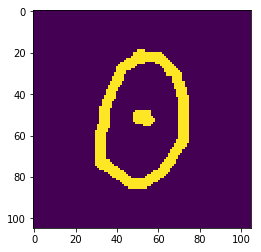

In [19]:
rootDir2 = './DumpPNG/'
I = plt.imread(rootDir2+'\\'+allFiles[0])
I = np.logical_not(I)
I = I.astype(float)
plt.imshow(I)
plt.show()

#### Next the image is distorted through an affine transform. This was done for data augmentation before pushing the images to the metric learner.

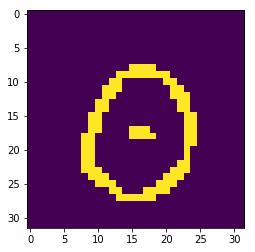

In [20]:
theta = rng.uniform(-np.pi/18, np.pi/18)
rhox = rng.uniform(-0.1,0.1)
rhoy = rng.uniform(-0.1,0.1)
sx = rng.uniform(0.9,1.1)
sy = rng.uniform(0.9,1.1)
tx = rng.uniform(-2,2)
ty = rng.uniform(-2,2)
c = np.cos(theta)
s = np.sin(theta)
Rot = np.array([[c,s],[-s,c]])
Shr = np. array([[1,rhox],[rhoy,1]])
Sca = np.array([[sx,0],[0,sy]])
A = reduce(np.dot, [Sca, Shr, Rot])
b = np.transpose([[tx,ty]])
try:
    Ainv = alg.inv(A)
    HomoA = np.concatenate((Ainv,-np.dot(Ainv,b)),axis=1)
    HomoA = np.concatenate((HomoA,[[0,0,1]]))
    I = affine_transform(I, Ainv)
except np.linalg.LinAlgError as err:
    if 'Singular matrix' in str(err):
        pass
    else:
        raise
        
I = I[4:100,4:100] # crop to 104 for clean division
I = rescale(I, 1.0 / 3.0, anti_aliasing=False)
#I = downscale_local_mean(I, (3, 3))
I[I >= 0.5] = 1
I[I < 0.5] = 0
plt.imshow(I)

In [21]:
ntrain = 20
feat_mtx = np.zeros((6*ntrain,1024),dtype = float)
feat_mtx[0:(6*ntrain):6,:] = I.flatten()

In [22]:
def load_image(fn):
    # Input: filename of image
    # 
    # Output:
    # n^2 length vector (32x32)
    
    I = plt.imread(fn)
    I = np.array(I,dtype=float)
    I = I[4:100,4:100]
    I = rescale(I, 1.0 / 3.0, anti_aliasing=False)
    I = I.astype(bool)
    I = I.flatten()
    return I

#### The feature matrix is created by flattening all of the images into vectors of 1s and 0s. This is then visualized in the plot.

In [26]:
feature_mtx = np.zeros((len(allFiles),1024))
for i, file in enumerate(allFiles):
    filepath = './DumpPNG/' + file
    feature_mtx[i,:] = load_image(filepath)
feature_mtx = np.logical_not(feature_mtx)

#### This plot shows the pixels in each of the 1000 images lit up in yellow. This represents the feature matrix for LMNN.

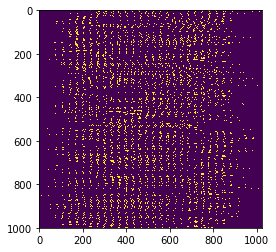

In [27]:
np.shape(feature_mtx)
# show the first 1000 images unrolled
plt.imshow(feature_mtx[:1000][:1024])
plt.show()

### Evaluate the model by training a LMNN classifier:

#### Because this model takes very long to train, the Mahalanobis matrices from previous runs were saved and loaded for demonstration.

In [34]:
# Parameters
nrun = 20 # number of classification runs
fname_label = 'class_labels.txt' # where class labels are stored for each run

In [35]:
def classification_run(folder,f_load,f_cost,ftype='cost'):
    # Compute error rate for one run of one-shot classification
    #
    # Input
    #  folder : contains images for a run of one-shot classification
    #  f_load : itemA = f_load('file.png') should read in the image file and process it
    #  f_cost : f_cost(itemA,itemB) should compute similarity between two images, using output of f_load
    #  ftype  : 'cost' if small values from f_cost mean more similar, or 'score' if large values are more similar
    #
    # Output
    #  perror : percent errors (0 to 100% error)
    # 
    assert ((ftype=='cost') | (ftype=='score'))

    # get file names
    with open(folder+'/'+fname_label) as f:
	    content = f.read().splitlines()
    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]
    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()	
    ntrain = len(train_files)
    ntest = len(test_files)

    # load the images (and, if needed, extract features)
    train_items = [f_load(f) for f in train_files]
    test_items  = [f_load(f) for f in test_files ]

    # Augment with 5 affine transforms
    # Creates 6 total examples per training item
    nexample = 6
    feat_mtx = np.zeros((nexample*ntrain,1024),dtype=float)
    for i, item in enumerate(train_items):
        I = rescale(item, 1.0 / 3.0, anti_aliasing=False)
        I = I.astype(bool)
        I = I.astype(float)
        feat_mtx[(nexample*i),:] = I.flatten()
        for j in range(1,nexample):
            feat_mtx[(nexample*i)+j,:] = AffineTransImg(item)

    # gather the class numbers for each file
    classes = np.repeat(np.arange(1,ntrain+1),nexample)

    Y = classes
    X = feat_mtx

    # setting up LMNN
    # tried 5 nearest neighbors (the 5 affine transforms of training data)
    # Takes very long to train, so there is a block for preloaded matrices
    lmnn = metric_learn.LMNN(k=5, min_iter=50, max_iter=1000, learn_rate=1e-6, regularization=1)

    # fit the data!
    # Could take up to 30 minutes per run
    # Use already saved matrices to save time
    try:
        Minv = np.load(folder+'Minv.npy')
    except FileNotFoundError:
        print("Matrix file not available.\n")
        print("Fitting data...\n")
        lmnn.fit(X, Y)
    # Save Mahalanobis metric matrix as a file for later
        Minv = lmnn.metric()
        np.save(folder+'Minv.npy', Minv)
    
    

    # compute cost matrix
    costM = np.zeros((ntest,ntrain),float)
    for i in range(ntest):
	    for c in range(ntrain):
		    costM[i,c] = f_cost(test_items[i],train_items[c],Minv)
    
    if ftype == 'cost':
	    YHAT = np.argmin(costM,axis=1)
    elif ftype == 'score':
	    YHAT = np.argmax(costM,axis=1)
    else:
	    assert False

    # compute the error rate
    correct = 0.0
    for i in range(ntest):
	    if train_files[YHAT[i]] == answers_files[i]:
		    correct += 1.0
    pcorrect = 100 * correct / ntest
    perror = 100 - pcorrect
    return perror

In [36]:
def ModHausdorffDistance(itemA,itemB,Minv):
    # Modified Hausdorff Distance
    #
    # Input
    #  itemA : [n x 2] coordinates of "inked" pixels
    #  itemB : [m x 2] coordinates of "inked" pixels
    #
    #  M.-P. Dubuisson, A. K. Jain (1994). A modified hausdorff distance for object matching.
    #  International Conference on Pattern Recognition, pp. 566-568.
    #
    itemA = rescale(itemA, 1.0 / 3.0, anti_aliasing=False).flatten()
    itemB = rescale(itemB, 1.0 / 3.0, anti_aliasing=False).flatten()
    
    items = np.stack((itemA, itemB))
    D = pdist(items, metric='mahalanobis', VI=Minv)
    return D

In [37]:
def LoadImgAsPoints(fn):
    # Load image file and return coordinates of 'inked' pixels in the binary image
    # 
    # Output:
    #  D : [n x 2] rows are coordinates
    I = imread(fn,flatten=True)
    I = np.array(I,dtype=bool)
    I = np.logical_not(I)

    # crop it to 96x96 for easy rescaling
    I = I[4:100,4:100]
    #I = rescale(I, 1.0 / 3.0, anti_aliasing=False)
    #I = resize(I, (I.shape[0] / 3, I.shape[1] / 3), anti_aliasing=False)
    #I = downscale_local_mean(I, (3, 3))
    #I = I.astype(bool)
    #I = I.astype(float)
    return I

In [38]:
def AffineTransImg(I):
    # Input: 
    # Image ndarray of floats
    #
    # Output:
    # Affine tranformed image, flattened to 1D
    theta = rng.uniform(-np.pi/18, np.pi/18)
    rhox = rng.uniform(-0.1,0.1)
    rhoy = rng.uniform(-0.1,0.1)
    sx = rng.uniform(0.9,1.1)
    sy = rng.uniform(0.9,1.1)
    tx = rng.uniform(-2,2)
    ty = rng.uniform(-2,2)
    c = np.cos(theta)
    s = np.sin(theta)
    Rot = np.array([[c,s],[-s,c]])
    Shr = np. array([[1,rhox],[rhoy,1]])
    Sca = np.array([[sx,0],[0,sy]])
    A = reduce(np.dot, [Sca, Shr, Rot])
    b = np.transpose([[0,0]])
    try:
        Ainv = alg.inv(A)
        HomoA = np.concatenate((Ainv,-np.dot(Ainv,b)),axis=1)
        HomoA = np.concatenate((HomoA,[[0,0,1]]))
        I = affine_transform(I, Ainv)
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            pass
        else:
            raise     
    I = downscale_local_mean(I, (3, 3))
    I[I >= 0.5] = 1
    I[I < 0.5] = 0
    
    I = I.flatten()
    return(I)

In [39]:
if __name__ == "__main__":
	#
	# Running this demo should lead to a result of 38.8 percent errors.
	#
	#   M.-P. Dubuisson, A. K. Jain (1994). A modified hausdorff distance for object matching.
	#     International Conference on Pattern Recognition, pp. 566-568.
	#
	# ** Models should be trained on images in 'images_background' directory to avoid 
	#  using images and alphabets used in the one-shot evaluation **
	#
	print ('One-shot classification demo with Large Margin Nearest Neighbors')
	perror = np.zeros(nrun)
	for r in range(1,nrun+1):
		rs = str(r)
		if len(rs)==1:
			rs = '0' + rs		
		perror[r-1] = classification_run('run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
		print (" run " + str(r) + " (error " + str(	perror[r-1] ) + "%)")		
	total = np.mean(perror)
	print (" average error " + str(total) + "%")

One-shot classification demo with Large Margin Nearest Neighbors
 run 1 (error 75.0%)
 run 2 (error 95.0%)
 run 3 (error 95.0%)
 run 4 (error 90.0%)
 run 5 (error 85.0%)
 run 6 (error 90.0%)
 run 7 (error 100.0%)
 run 8 (error 95.0%)
 run 9 (error 90.0%)
 run 10 (error 100.0%)
 run 11 (error 95.0%)
 run 12 (error 85.0%)
 run 13 (error 85.0%)
 run 14 (error 80.0%)
 run 15 (error 95.0%)
 run 16 (error 90.0%)
 run 17 (error 95.0%)
 run 18 (error 85.0%)
 run 19 (error 90.0%)
 run 20 (error 95.0%)
 average error 90.5%


#### Using this metric learning method, the error is very large. In fact this technique only resulted in error close to random guessing (90.5% vs 95%). Unfortunately the LMNN algorithm as implemented is very slow. Additional data augmentation (possibly through other transformations besides affine distortion) and longer time for training would be necessary to see improvement.